In [1]:
import dask.dataframe as dd
from math import radians, cos, sin, asin, sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

date_format = '%Y-%m-%d %H:%M:%S'

In [2]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 
    return c * r

RANDOM_SEED = 5
SAMPLE_FRACTION = 0.1

In [3]:
DATA_FILE_PATHS = [f"data/JC-2022{i:02d}-citibike-tripdata.csv" for i in range(1, 12)]

def load_data(file_paths, sample_fraction):
    data_arr = [
        dd.read_csv(file_path).sample(frac=sample_fraction, random_state=RANDOM_SEED)
        for file_path in file_paths
    ]
    data = dd.concat(data_arr)
    return data

all_data = load_data(DATA_FILE_PATHS, SAMPLE_FRACTION)

all_data = all_data.assign(
    started_at=dd.to_datetime(all_data.started_at, format=date_format),
    ended_at=dd.to_datetime(all_data.ended_at, format=date_format)
)

all_data = all_data.assign(
    start_hour=all_data.started_at.dt.hour,
    week_number=all_data.started_at.dt.isocalendar().week
)

In [4]:
trips_per_start_hour = all_data.groupby(
    ['week_number','start_hour']).agg({'ride_id': 'count'})

trips_per_start_hour = trips_per_start_hour.compute().unstack()
trips_per_start_hour.columns = trips_per_start_hour.columns.droplevel()

The heatmap visualizes the number of trips per start hour for each week in the dataset. The x-axis represents the start hour (0-23), and the y-axis represents the week number. Darker shades represent higher trip counts, while lighter shades represent lower trip counts. This visualization is useful for identifying patterns in hourly trip frequency across weeks.

The busiest time is between 5pm to 8pm. There's also a spike between 7 and 8 pm. Usual commuting work time.

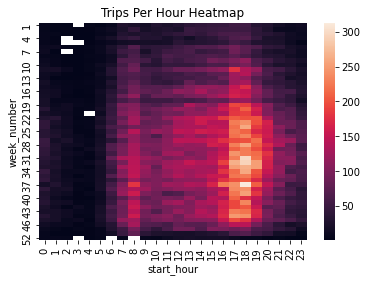

In [5]:
ax = plt.axes()
sns.heatmap(trips_per_start_hour)
ax.set_title('Trips Per Hour Heatmap')

all_stations = set(
    list(all_data.start_station_id.dropna().unique()) + 
    list(all_data.end_station_id.dropna().unique()))

stations_info = pd.DataFrame(index=all_stations)

In [6]:
all_data = all_data.assign(
    trip_duration=(all_data.ended_at - all_data.started_at).dt.seconds
)

all_data = all_data.assign(
    trip_distance=all_data.apply(
        lambda x: haversine(
            x.start_lng, x.start_lat, x.end_lng, x.end_lat
        ),
        axis=1
    ),
    is_member=all_data.member_casual == 'member',
    is_casual=all_data.member_casual == 'casual',
    weekday=all_data.started_at.dt.weekday,
    is_peak_hour=all_data.start_hour.isin([8, 17, 18, 19])
)

all_data = all_data.assign(
    is_weekend=all_data.weekday > 5,
    is_weekday=all_data.weekday <= 5
)


/opt/conda/miniconda3/lib/python3.8/site-packages/dask/dataframe/core.py:4441: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


In [7]:
avg_daily_trips_per_start_hour = trips_per_start_hour.mean(axis=1)

stations_info['avg_daily_trips'] = all_data.groupby('start_station_id').ride_id.count().compute()
stations_info['avg_daily_trips'] = stations_info['avg_daily_trips'] / 365

stations_info['lon'] = all_data.groupby('start_station_id').start_lng.mean().compute()
stations_info['lat'] = all_data.groupby('start_station_id').start_lat.mean().compute()

stations_info = stations_info.dropna(subset=['lon', 'lat'])

stations_info_std = StandardScaler().fit_transform(stations_info)

k_values = range(2, 11)
silhouette_scores = []

This plot displays the silhouette scores for different numbers of clusters (k) when applying K-Means clustering on the standardized station information data. The x-axis represents the number of clusters, and the y-axis represents the silhouette score. Higher silhouette scores indicate better-defined clusters.

Insights:

The optimal number of clusters can be determined by finding the value of k that results in the highest silhouette score. In this case, it appears that the optimal k value is around 4.
This information is helpful when deciding how many clusters to use for K-Means clustering to best represent the underlying structure of the data.

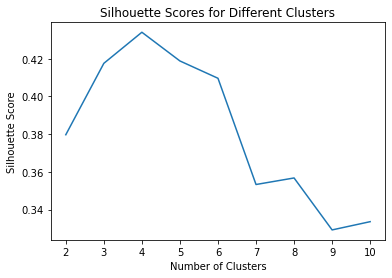

In [8]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kmeans_labels = kmeans.fit_predict(stations_info_std)
    silhouette_avg = silhouette_score(stations_info_std, kmeans_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(k_values, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different Clusters")
plt.show()

This scatterplot shows the result of applying PCA to the standardized station information data, reducing its dimensionality to two principal components (pca_1 and pca_2). Each point in the scatterplot represents a station, and the color of the point corresponds to the cluster assigned by K-Means clustering. The x-axis represents the first principal component (pca_1), and the y-axis represents the second principal component (pca_2).

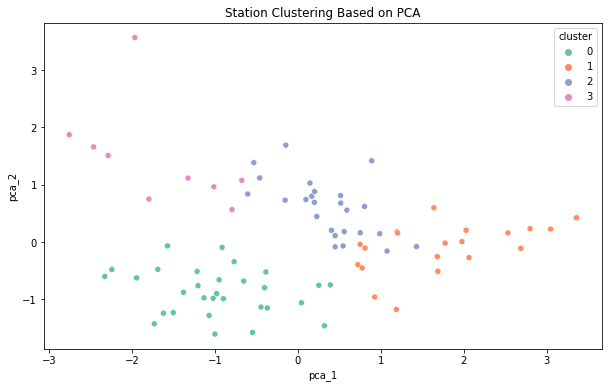

In [9]:
optimal_k = k_values[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_SEED)
stations_info['cluster'] = kmeans.fit_predict(stations_info_std)

pca = PCA(n_components=2)
stations_info_pca = pca.fit_transform(stations_info_std)
stations_info['pca_1'] = stations_info_pca[:, 0]
stations_info['pca_2'] = stations_info_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="pca_1", y="pca_2", hue="cluster", data=stations_info, palette="Set2")
plt.title("Station Clustering Based on PCA")
plt.show()
